In [18]:
import orca
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection as pc
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
%matplotlib inline
os.chdir('/home/max/projects/activitysynth/activitysynth/')

In [2]:
from activitysynth.scripts import datasources, models, variables

/home/max/anaconda3/envs/ual-model/lib/python3.7/site-packages/urbansim-3.1.1-py3.7.egg/urbansim/utils/yamlio.py:162: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  d = yaml.load(f)


Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt_simple'
Registering model step 'WLCM_gen_tt'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM_gen_tt_TWEAK'
Registering model step 'WLCM'


In [12]:
scenarios = ['baseline', 'a_lt', 'a_ht', 'b_lt', 'b_ht', 'c_lt', 'c_ht']
scenario_labels = ['Base0', 'A2', 'A3', 'B5', 'B6', 'C5', 'C6']
scenario_dict = {}

In [34]:
tech_label_dict = {'lt': 'BAU', 'ht': 'VTO Success'}

In [4]:
def load_PILATES_outputs(scenario):
    input_file_format = 'csv'
    input_data_dir = 'https://beam-outputs.s3.amazonaws.com/pilates-outputs/15thSep2019/{0}/urbansim'.format(scenario)

    formattable_fname_dict = {
        'parcels': 'parcels.{0}',
        'buildings': 'buildings.{0}',
        'jobs': 'jobs.{0}',
        'establishments': 'establishments.{0}',
        'households': 'households.{0}',
        'persons': 'persons.{0}',
        'rentals': 'craigslist.{0}',
        'units': 'units.{0}',
        'mtc_skims': 'mtc_skims.{0}',
        'beam_skims_raw': '15.skims.csv.gz',
        'beam_skims_imputed': 'beam_skims_imputed.{0}',
        'drive_nodes': 'drive_nodes.{0}',
        'drive_edges': 'drive_edges.{0}',
        'drive_access_vars': 'drive_net_vars.{0}',
        'walk_nodes': 'walk_nodes.{0}',
        'walk_edges': 'walk_edges.{0}',
        'walk_access_vars': 'walk_net_vars.{0}',
        'zones': 'zones.{0}',
        'zone_access_vars': 'zones_w_access_vars.{0}',
    }

    def format_fname_dict(formattable_fname_dict, format='csv'):
        formatted_dict = {
            k: v.format('csv')
            for k, v in formattable_fname_dict.items()}
        return formatted_dict

    input_fnames = format_fname_dict(
                formattable_fname_dict, input_file_format)

    orca.add_injectable('input_file_format', input_file_format)
    orca.add_injectable('input_data_dir', input_data_dir)
    orca.add_injectable('input_fnames', input_fnames)
    orca.add_injectable('store', None)

In [5]:
orca.broadcast(
    'jobs', 'persons', cast_index=True, onto_on='job_id')

In [13]:
for i, scenario in enumerate(scenarios):
    print('processing scenario {0}'.format(scenario))
    load_PILATES_outputs(scenario)
    orca.run(['initialize_network_walk', 'initialize_network_small', 'initialize_imputed_skims'])
    orca.run(['skims_aggregations'])
    commute_df = orca.merge_tables()
    home_df = orca.merge_tables(
        'households', ['households', 'units', 'buildings', 'parcels', 'zones'], columns=[
            'persons', 'unit_residential_rent', 'unit_residential_price', 'zone_id', 'area',
            'total_jobs_gen_tt_CAR_15', 'total_jobs_gen_tt_CAR_30', 'total_jobs_gen_tt_CAR_45'])
    work_df = orca.merge_tables(
        'persons', ['persons', 'jobs', 'buildings', 'parcels', 'zones'], columns=[
            'job_id', 'zone_id', 'area', 'total_jobs_gen_tt_CAR_15',
            'total_jobs_gen_tt_CAR_30', 'total_jobs_gen_tt_CAR_45'])
    scenario_dict[scenario_labels[i]] = {'home': home_df, 'work': work_df}
    orca.clear_cache()

processing scenario baseline
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_imputed_skims'
Time to execute step 'initialize_imputed_skims': 132.86 s
Total time to execute iteration 1 with iteration value None: 132.86 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
processing scenario a_lt
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_imputed_skims'
Time to execute step 'initialize_imputed_skims': 123.13 s
Total time to execute iteration 1 with iteration value None: 123.13 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0

In [35]:
scenario_names = {'a': 'sharing is caring', 'b': 'tech takeover', 'c': 'all about me'}
tech_names = {'lt': 'BAU', 'ht': 'VTO Success'}

# Distribution of jobs accessibility

## 15 min travel time

### Vehicle Tech $\times$ Scenario

#### KDE

In [25]:
scenario.upper()

'C'

Text(0.5, 0, 'jobs w/i 15 minutes from each residential unit')

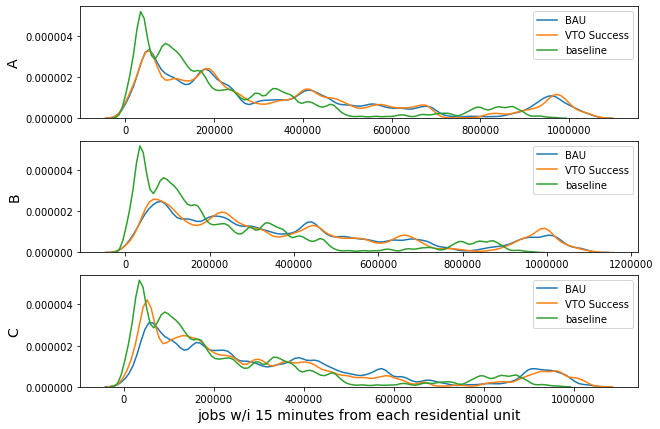

In [27]:
fig, axarr = plt.subplots(3, 1, figsize=(10,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        scenario_label = scenario_labels[scenarios.index(scenario + '_' + tech)]
        sns.kdeplot(scenario_dict[scenario_label]['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label=tech_label_dict[tech])
    sns.kdeplot(scenario_dict['Base0']['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(scenario.upper(), fontsize=14, )
axarr[2].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

Text(0.5, 0, 'jobs w/i 15 minutes from each residential unit')

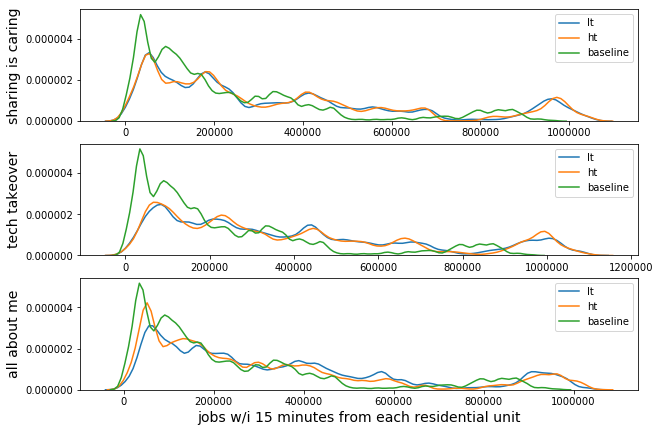

In [29]:
fig, axarr = plt.subplots(3, 1, figsize=(10,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        scenario_label = scenario_labels[scenarios.index(scenario + '_' + tech)]
        sns.kdeplot(scenario_dict[scenario_label]['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label=tech)
    sns.kdeplot(scenario_dict['Base0']['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(scenario, fontsize=14)
axarr[2].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

#### CDF

Text(0.5, 0, 'Jobs w/i 15 Min. (gen_tt_CAR)')

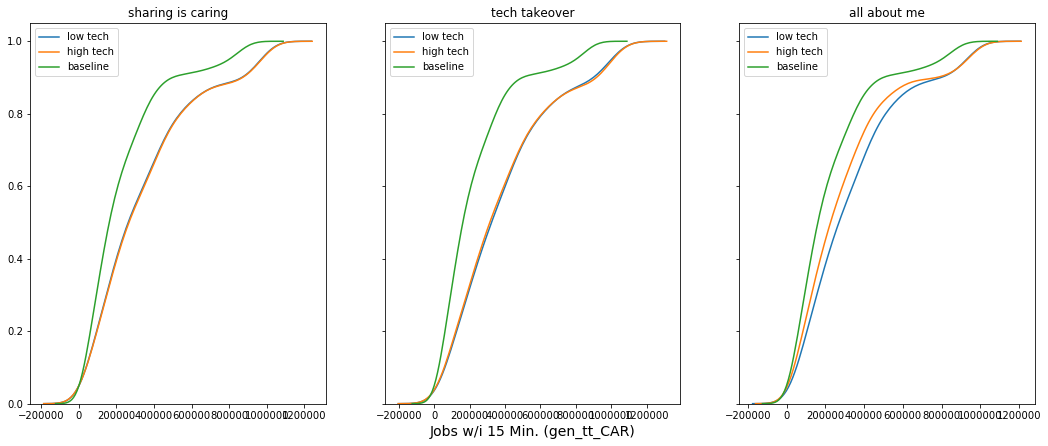

In [30]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.kdeplot(
            df['total_jobs_gen_tt_CAR_15'],
            ax=axarr[i], label=tech_names[tech], cumulative=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.kdeplot(
            df['total_jobs_gen_tt_CAR_15'],
            ax=axarr[i], label='baseline', cumulative=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
axarr[1].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
# axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

### Scenario $\times$ Vehicle Tech

#### KDE

Text(0.5, 0, 'jobs w/i 15 minutes from each residential unit')

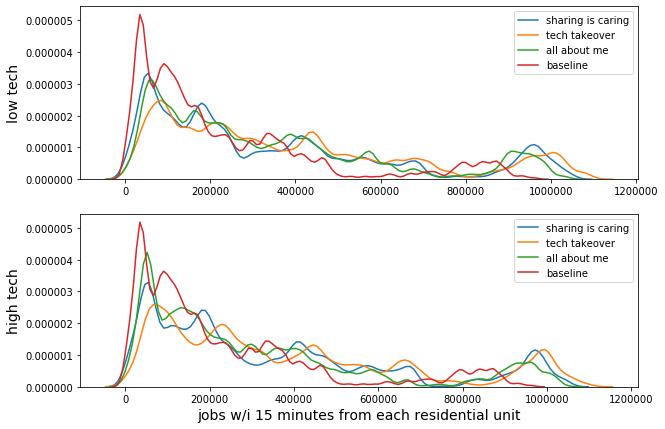

In [31]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        sns.kdeplot(scenario_dict[scenario + '_' + tech]['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label=scenario_names[scenario])
    sns.kdeplot(scenario_dict['baseline']['home']['total_jobs_gen_tt_CAR_15'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(tech_names[tech], fontsize=14)
axarr[1].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

#### Rank-Ordered Distribution

Text(0.5, 0, 'residential unit (rank)')

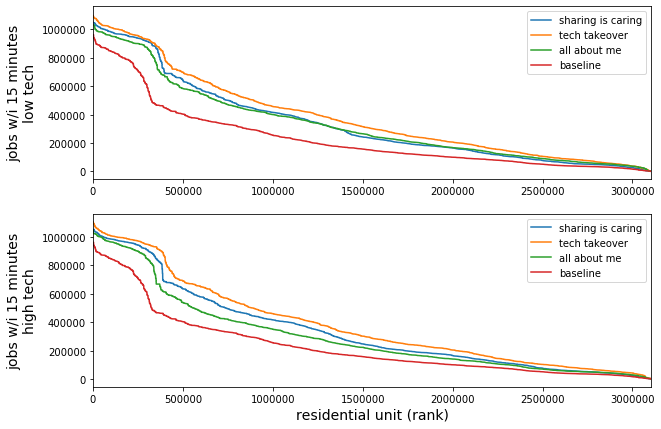

In [32]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        scenario_dict[scenario + '_' + tech]['home'].sort_values(
            'total_jobs_gen_tt_CAR_15', ascending=False).reset_index()['total_jobs_gen_tt_CAR_15'].plot(
                ax=axarr[i], label=scenario_names[scenario])
    scenario_dict['baseline']['home'].sort_values(
            'total_jobs_gen_tt_CAR_15', ascending=False).reset_index()['total_jobs_gen_tt_CAR_15'].plot(
        ax=axarr[i], label='baseline')
    axarr[i].set_ylabel('jobs w/i 15 minutes\n' + tech_names[tech], fontsize=14)
    axarr[i].legend(loc=1)
axarr[1].set_xlabel('residential unit (rank)', fontsize=14)

#### CDF

Text(0, 0.5, 'Cumulative % of Residential Units')

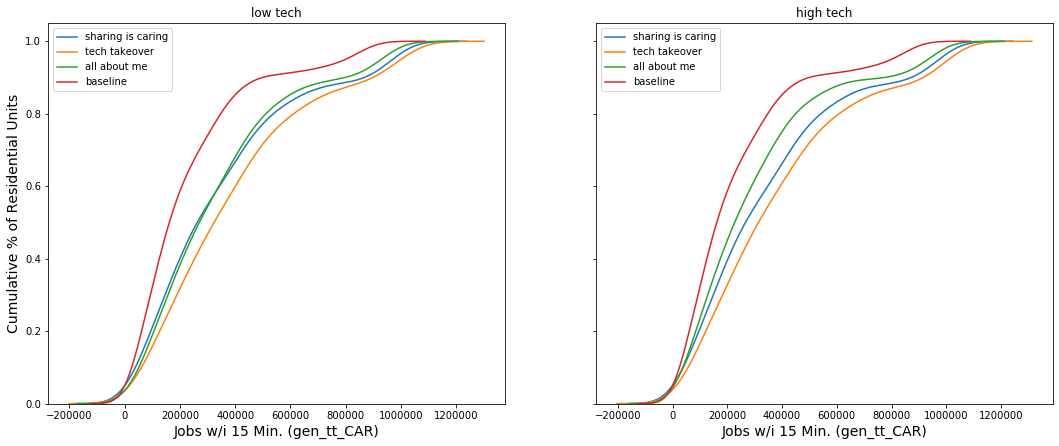

In [33]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.kdeplot(
            df['total_jobs_gen_tt_CAR_15'], 
            ax=axarr[i], label=scenario_names[scenario], cumulative=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.kdeplot(
            df['total_jobs_gen_tt_CAR_15'], 
            ax=axarr[i], label='baseline', cumulative=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Cumulative % of Residential Units', fontsize=14)

## 45 min. travel time

### Vehicle Tech $\times$ Scenario

#### KDE

Text(0.5, 0, 'jobs w/i 45 minutes from each residential unit')

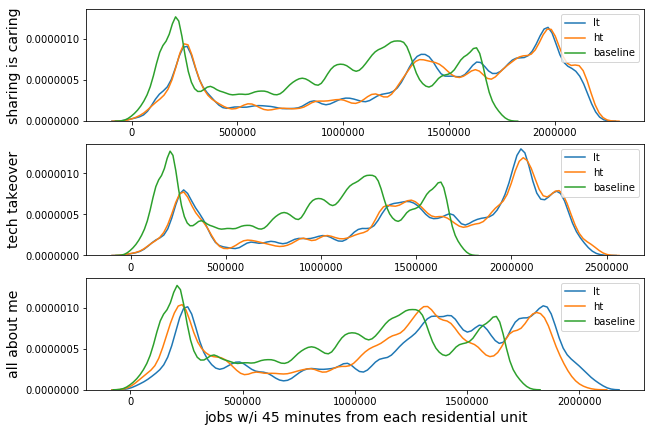

In [34]:
fig, axarr = plt.subplots(3, 1, figsize=(10,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        sns.kdeplot(scenario_dict[scenario + '_' + tech]['home']['total_jobs_gen_tt_CAR_45'], ax=axarr[i], label=tech)
    sns.kdeplot(scenario_dict['baseline']['home']['total_jobs_gen_tt_CAR_45'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(scenario_names[scenario], fontsize=14)
axarr[2].set_xlabel('jobs w/i 45 minutes from each residential unit', fontsize=14)

### Scenario $\times$ Vehicle Tech

#### KDE

Text(0.5, 0, 'jobs w/i 45 minutes from each residential unit')

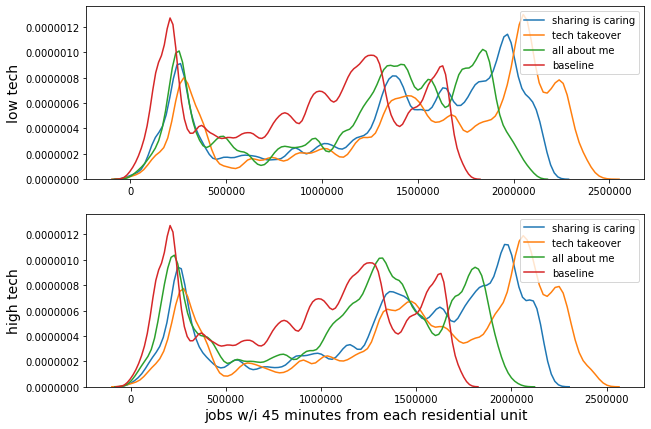

In [35]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        sns.kdeplot(scenario_dict[scenario + '_' + tech]['home']['total_jobs_gen_tt_CAR_45'], ax=axarr[i], label=scenario_names[scenario])
    sns.kdeplot(scenario_dict['baseline']['home']['total_jobs_gen_tt_CAR_45'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(tech_names[tech], fontsize=14)
axarr[1].set_xlabel('jobs w/i 45 minutes from each residential unit', fontsize=14)

#### Rank-ordered Distribution

Text(0.5, 0, 'residential unit (rank)')

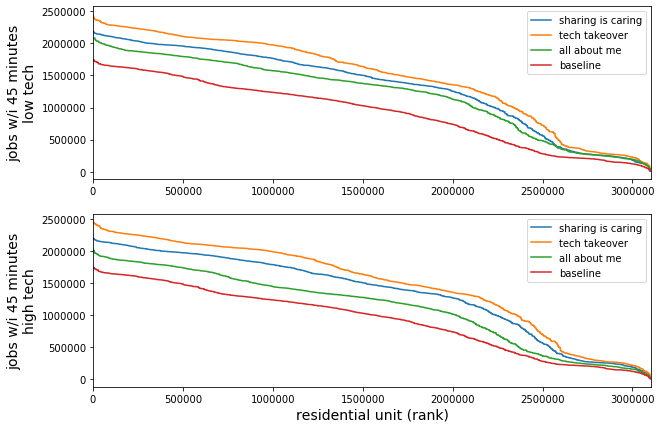

In [36]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        scenario_dict[scenario + '_' + tech]['home'].sort_values(
            'total_jobs_gen_tt_CAR_45', ascending=False).reset_index()['total_jobs_gen_tt_CAR_45'].plot(
                ax=axarr[i], label=scenario_names[scenario])
    scenario_dict['baseline']['home'].sort_values(
            'total_jobs_gen_tt_CAR_45', ascending=False).reset_index()['total_jobs_gen_tt_CAR_45'].plot(
        ax=axarr[i], label='baseline')
    axarr[i].set_ylabel('jobs w/i 45 minutes\n' + tech_names[tech], fontsize=14)
    axarr[i].legend(loc=1)
axarr[1].set_xlabel('residential unit (rank)', fontsize=14)

# Jobs accessibility vs. Rent

## 15 min. travel times

### Vehicle Tech $\times$ Scenario

#### Scatter with Linear Regression and 0.95 ci

Text(0, 0.5, 'Rent/Sqft')

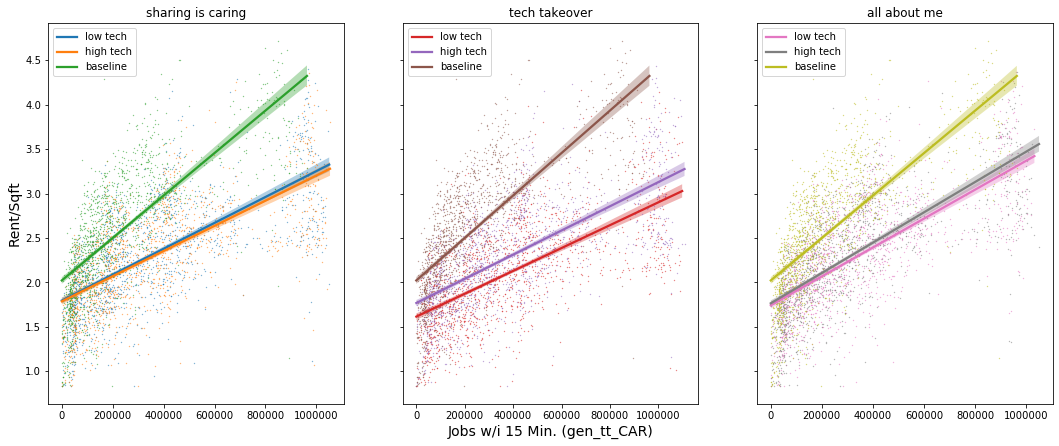

In [37]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        ax = sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], ci=95, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True, truncate=True)
        plt.setp(ax.collections[1], alpha=0.5)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    ax = sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], ci=95, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True, truncate=True)
    plt.setp(ax.collections[1], alpha=0.5)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with LOWESS

Text(0, 0.5, 'Rent/Sqft')

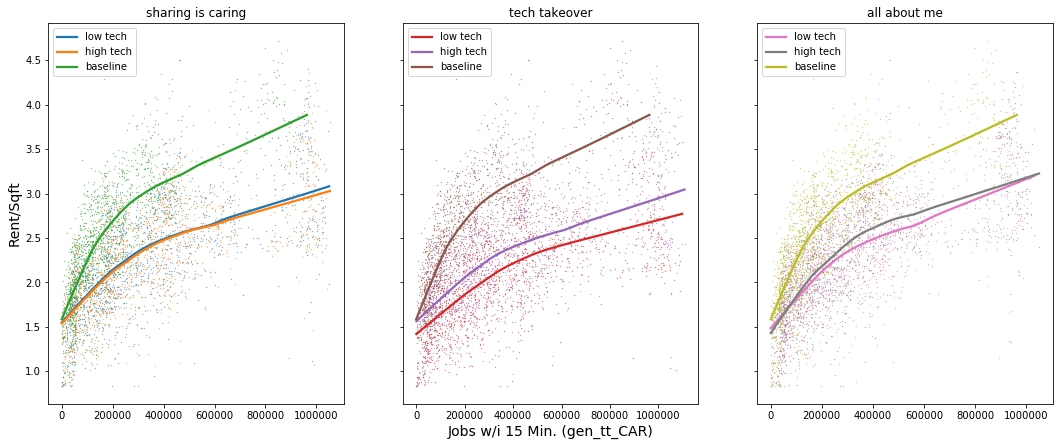

In [38]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], lowess=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True, truncate=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], lowess=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True, truncate=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
axarr[1].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter w/ regression on log(x)

/home/max/anaconda3/envs/ual-model/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


Text(0, 0.5, 'Rent/Sqft')

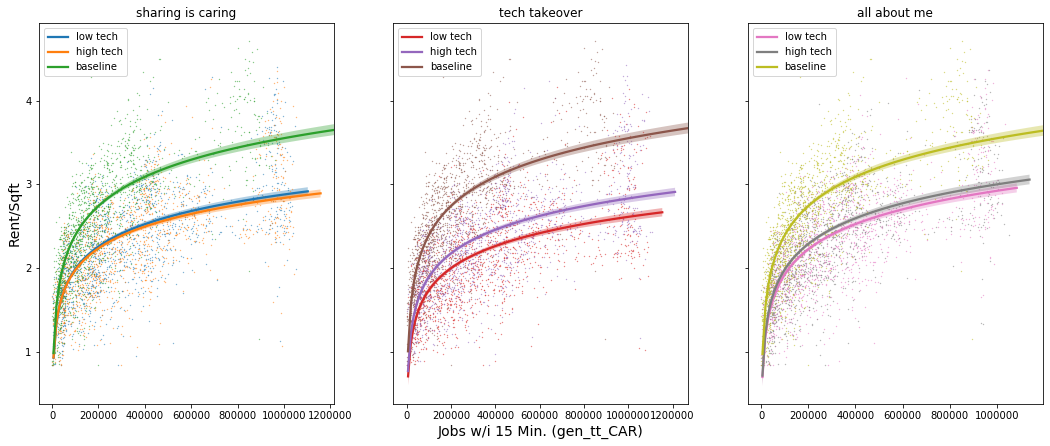

In [39]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], logx=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], logx=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with 3rd-order Polynomial Fit

Text(0, 0.5, 'Rent/Sqft')

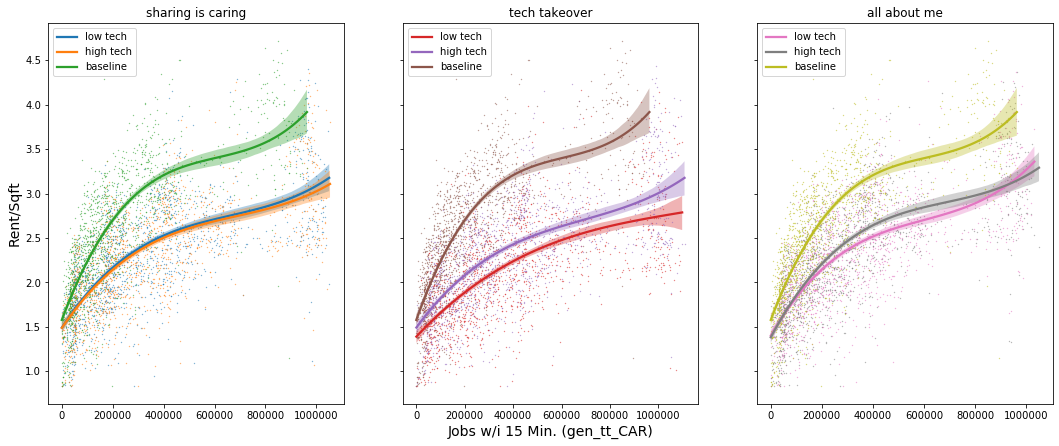

In [40]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], order=3, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True, truncate=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], order=3, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True, truncate=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

### Scenario $\times$ Vehicle Tech

#### Scatter with linear regression and 0.95 ci

Text(0, 0.5, 'Rent/Sqft')

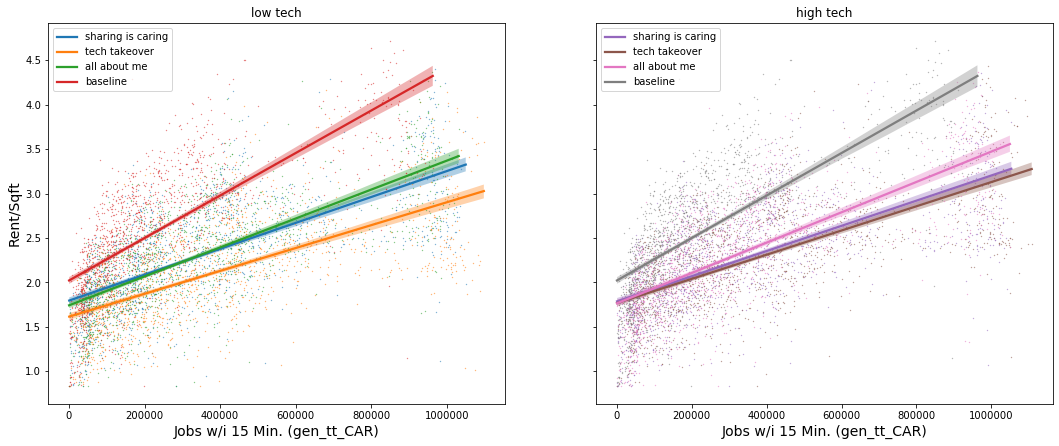

In [41]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True, truncate=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True, truncate=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with LOWESS

Text(0, 0.5, 'Rent/Sqft')

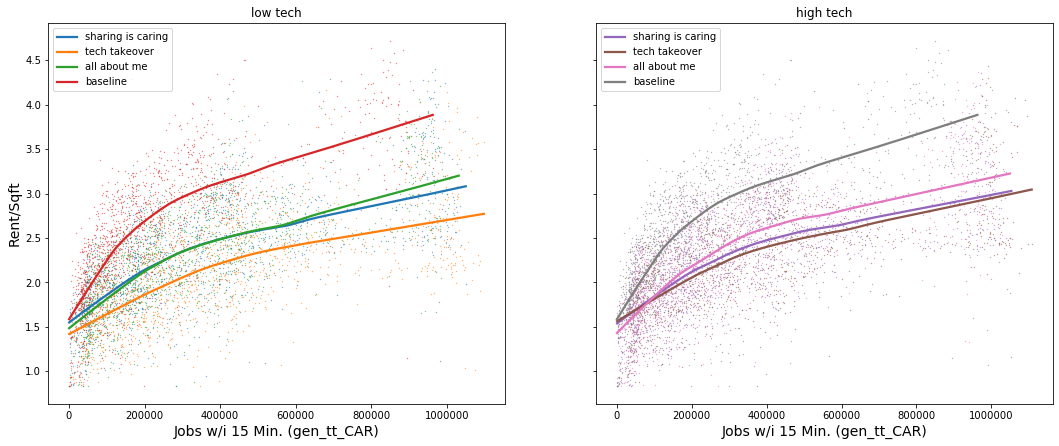

In [42]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, lowess=True, truncate=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, lowess=True, truncate=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter w/ regression on log(x)

Text(0, 0.5, 'Rent/Sqft')

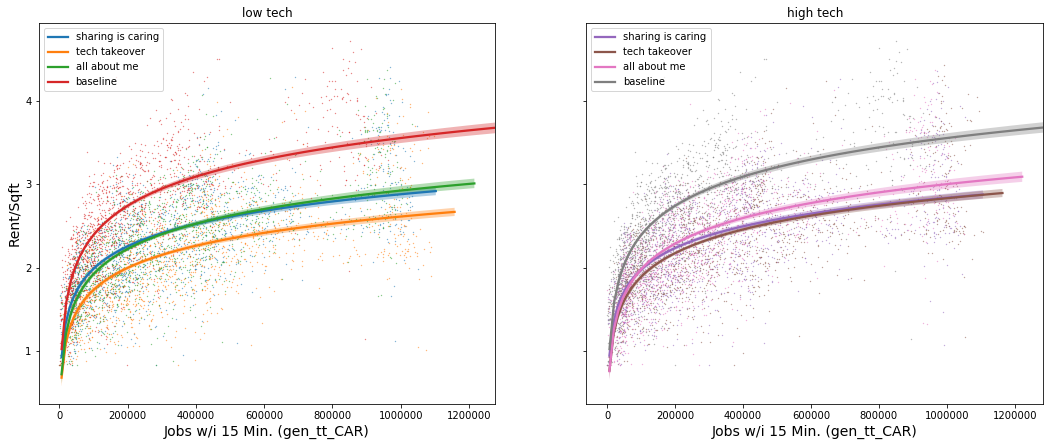

In [43]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], logx=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], logx=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with 3rd-order Polynomial Fit

Text(0, 0.5, 'Rent/Sqft')

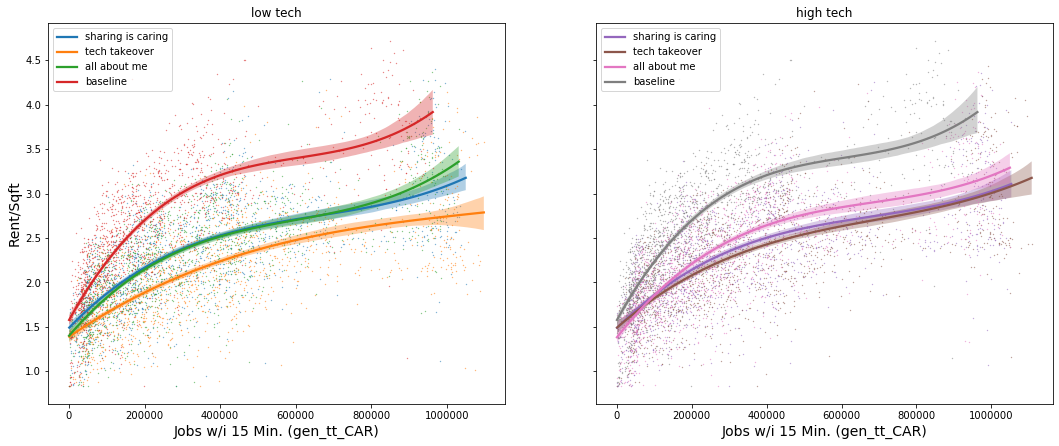

In [44]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        foo = sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], order=3, truncate=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    doo = sns.regplot(
            df['total_jobs_gen_tt_CAR_15'], df['unit_residential_rent'], order=3, truncate=True, scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

## 45 min. travel times

### Vehicle Tech $\times$ Scenario

#### Scatter with Linear Regression and 0.95 ci

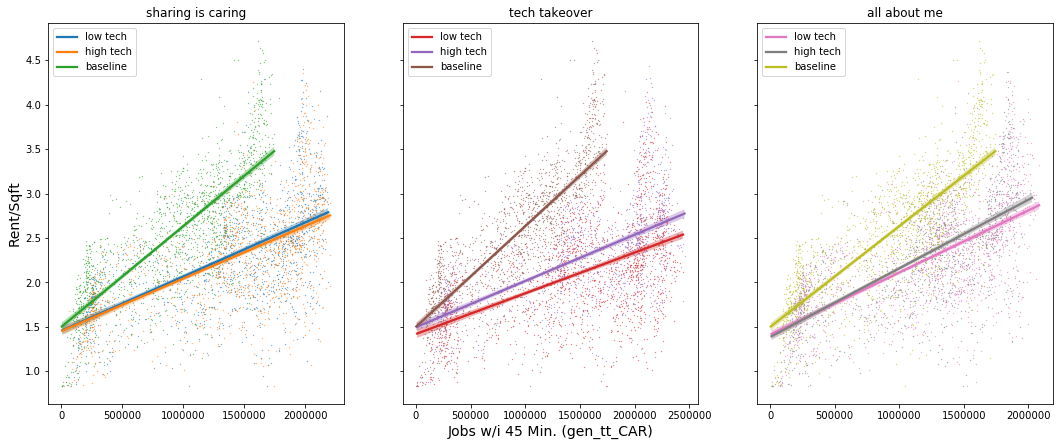

In [45]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Rent/Sqft', fontsize=14)


#### Scatter with LOWESS

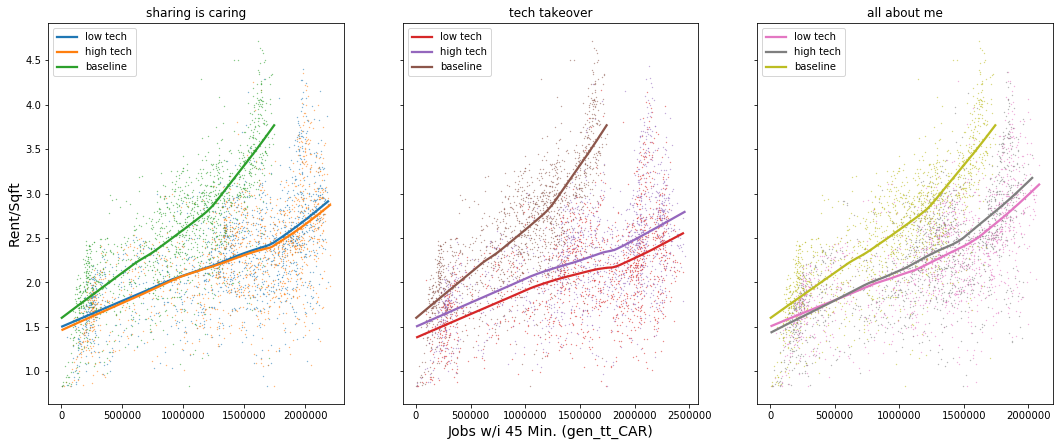

In [46]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True, lowess=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True, lowess=True,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Rent/Sqft', fontsize=14)


#### Scatter with log(x) Regression

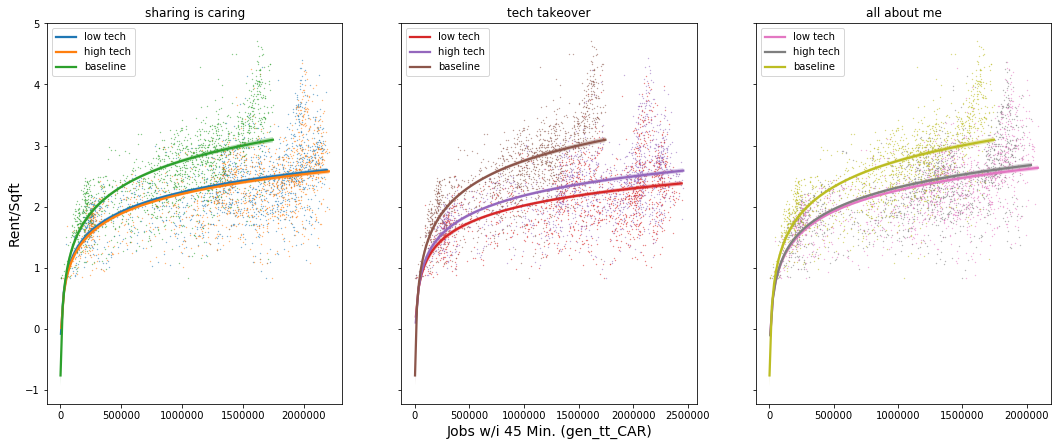

In [47]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            logx=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
        logx=True,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Rent/Sqft', fontsize=14)


#### Scatter with 3rd Order Polynomial Fit

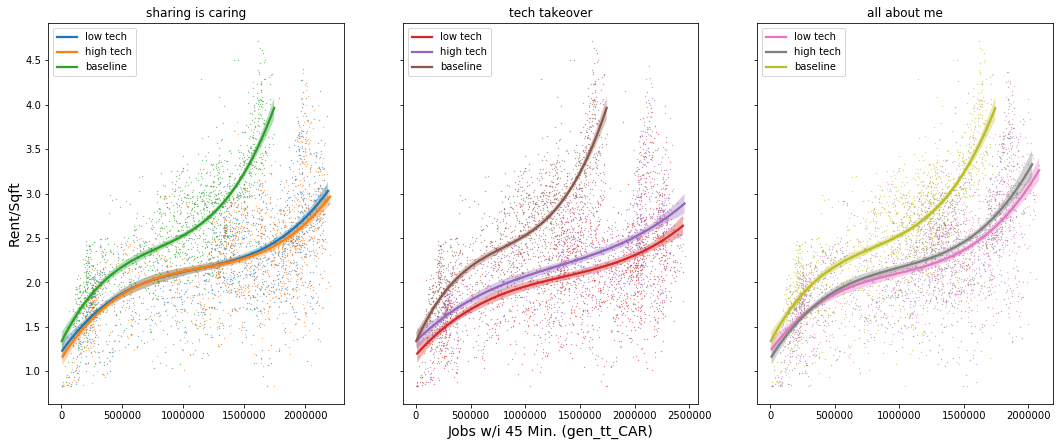

In [48]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            order=3,
            truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        order=3,
        truncate=True,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Rent/Sqft', fontsize=14)


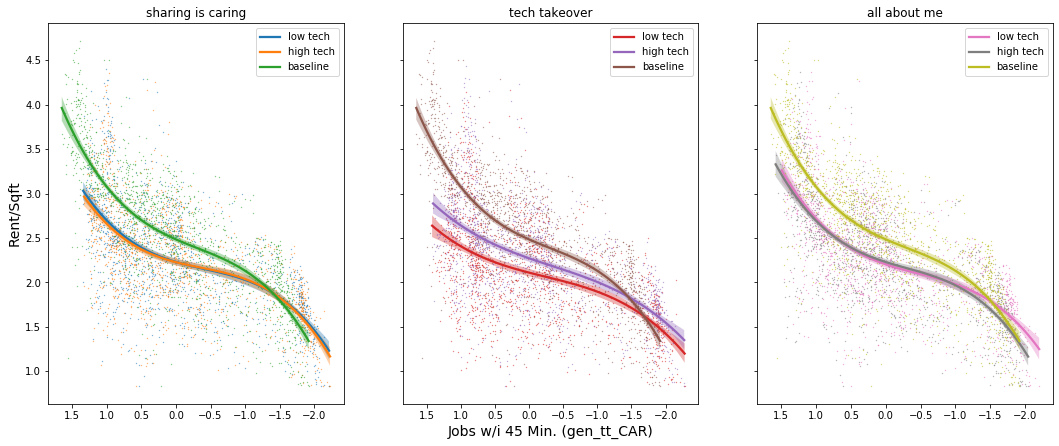

In [58]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            df['unit_residential_rent'],
            order=3,
            truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
        df['unit_residential_rent'],
        order=3,
        truncate=True,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Rent/Sqft', fontsize=14)


### Scenario $\times$ Vehicle Tech

#### Scatter with Linear Regression and 0.95 ci

KeyError: 'a_lt'

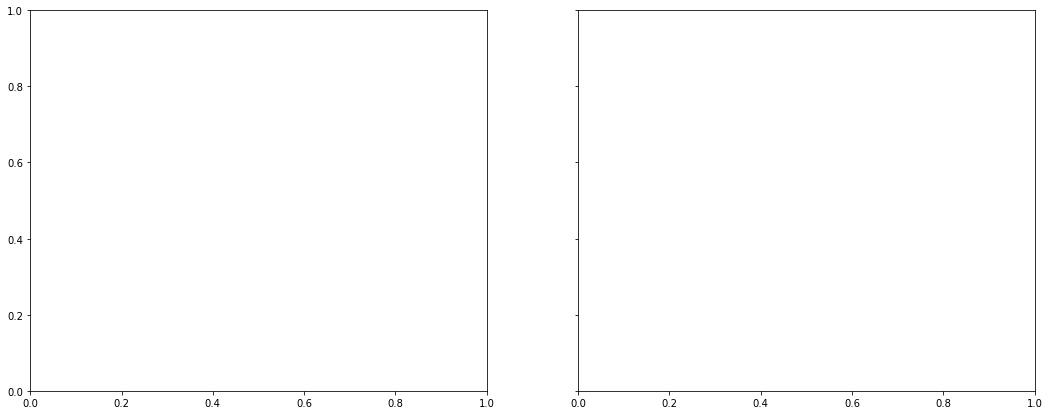

In [36]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with LOWESS

Text(0, 0.5, 'Rent/Sqft')

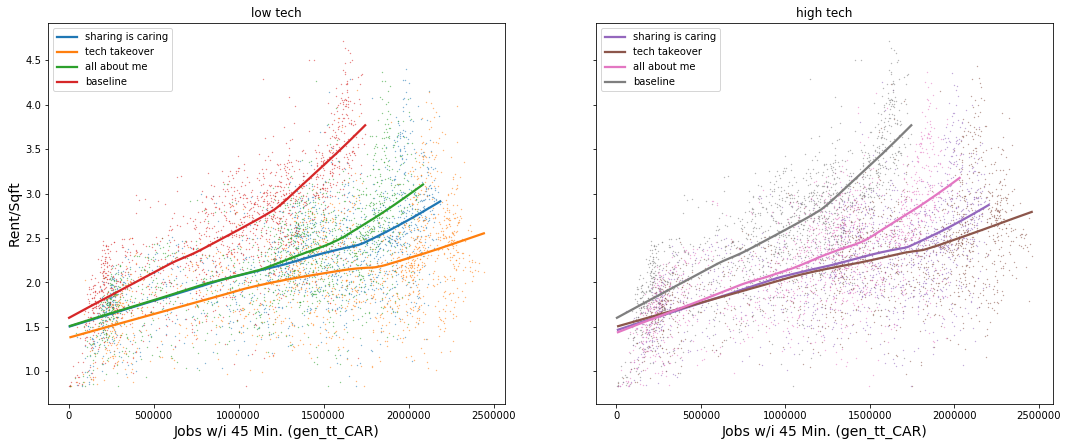

In [60]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            lowess=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
            lowess=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with log(x) Regression

Text(0, 0.5, 'Rent/Sqft')

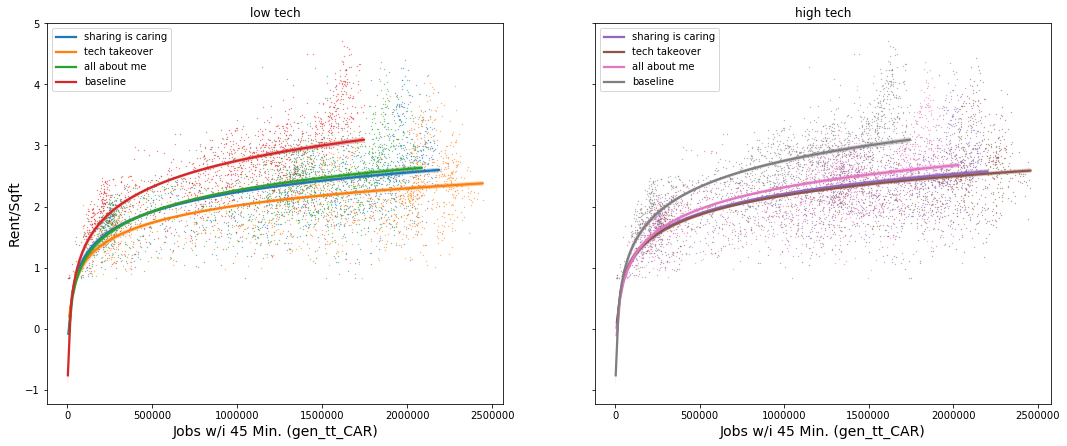

In [61]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            logx=True, 
            truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            logx=True, 
        truncate=True,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

#### Scatter with 3rd order Polynomial Fit

Text(0, 0.5, 'Rent/Sqft')

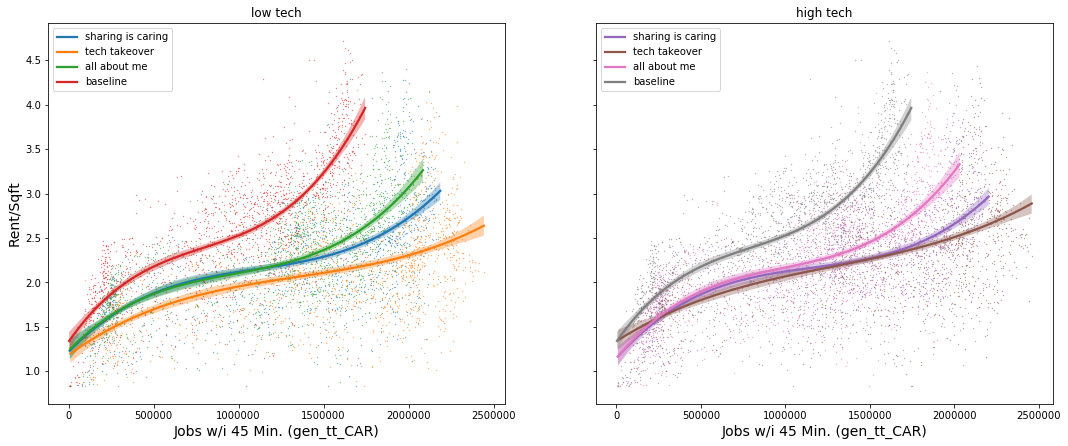

In [62]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            order=3, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
            order=3, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

Text(0, 0.5, 'Rent/Sqft')

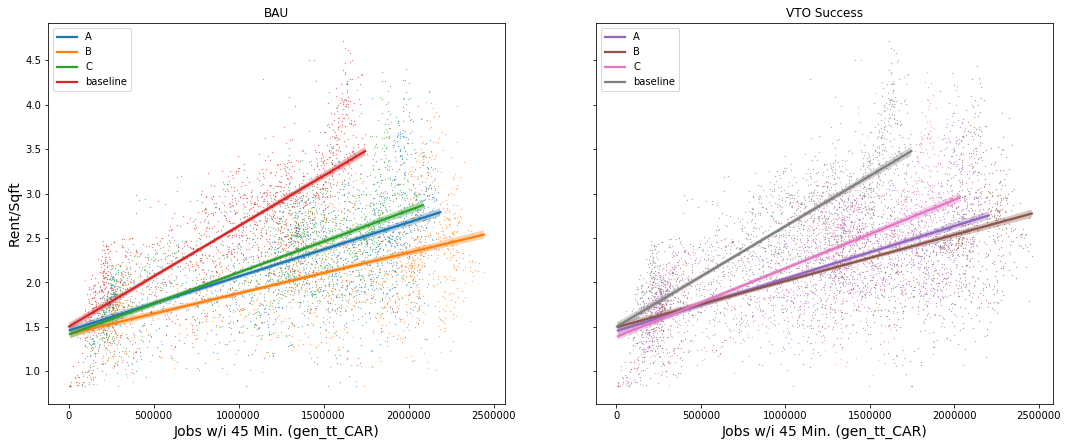

In [44]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        scenario_label = scenario_labels[scenarios.index(scenario + '_' + tech)]
        df = scenario_dict[scenario_label]['home'].groupby('zone_id').mean()
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
            truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario.upper()}, scatter=True)
    df = scenario_dict['Base0']['home'].groupby('zone_id').mean()
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'], df['unit_residential_rent'],
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
#     axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Rent/Sqft', fontsize=14)

Text(0, 0.5, 'Normalized Rent/Sqft')

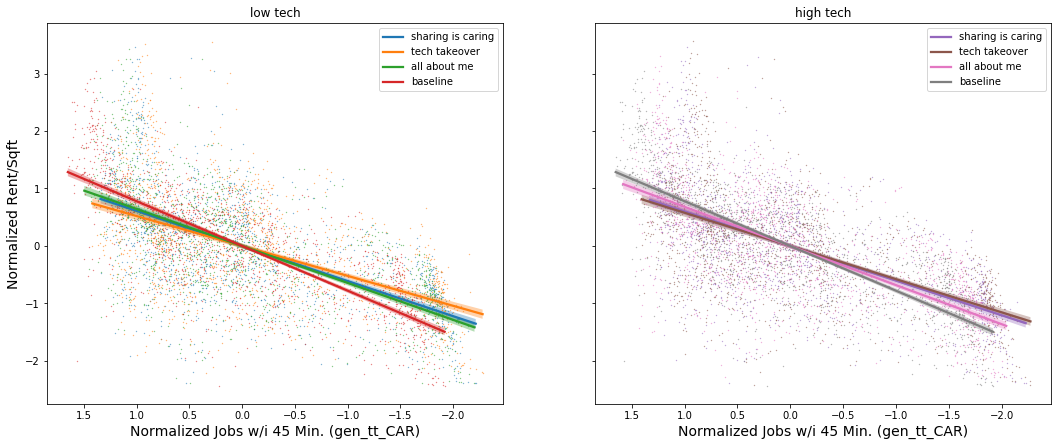

In [74]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').mean()
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (df['unit_residential_rent'] - df['unit_residential_rent'].mean()) / df['unit_residential_rent'].std(),
            truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').mean()
    sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
        (df['unit_residential_rent'] - df['unit_residential_rent'].mean()) / df['unit_residential_rent'].std(),
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Normalized Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
#     axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Normalized Rent/Sqft', fontsize=14)

# Sprawl vs. Density

In [180]:
landmarks = pd.read_csv('/home/max/projects/bayarea_urbansim/data/landmarks_w_taz.csv')
landmarks = landmarks.append(
    {'name': 'sj_state', 'lat': 37.335614, 'lng': -121.882151, 'taz1454': None}, ignore_index=True)
landmarks = landmarks.append(
    {'name': 'oak_12_st', 'lat':37.803986, 'lng':-122.271618, 'taz1454': None}, ignore_index=True)

In [181]:
landmarks_gdf = gpd.GeoDataFrame(
    landmarks, geometry=gpd.points_from_xy(landmarks.lng, landmarks.lat))

In [182]:
landmarks_gdf.crs = {'init': 'epsg:4326'}

In [183]:
taz_gdf = gpd.read_file('/home/data/spring_2019/base/Transportation_Analysis_Zones.shp')

In [184]:
merged = gpd.sjoin(landmarks_gdf, taz_gdf)
merged.rename(columns={'taz1454_right': 'taz1454'}, inplace=True)

In [185]:
landmarks = merged[landmarks.columns]

In [186]:
zones = orca.get_table('zones').to_frame()
zones.reset_index(inplace=True)
beam_skims_imputed = orca.get_table('beam_skims_imputed').to_frame()
for i, row in landmarks.iterrows():
    poi_taz = row['taz1454']
    zones['poi_taz'] = poi_taz
    m = pd.merge(
        zones, beam_skims_imputed,
        left_on=['zone_id', 'poi_taz'],
        right_on=['from_zone_id', 'to_zone_id'])
    m.set_index('zone_id', inplace=True)
    orca.add_column('zones', 'dist_to_' + row['name'], m['dist'])

In [187]:
zones = orca.get_table('zones').to_frame()

In [188]:
zones['min_dist_to_cbd'] = zones[['dist_to_embarcadero', 'dist_to_oak_12_st', 'dist_to_sj_state']].min(axis=1)

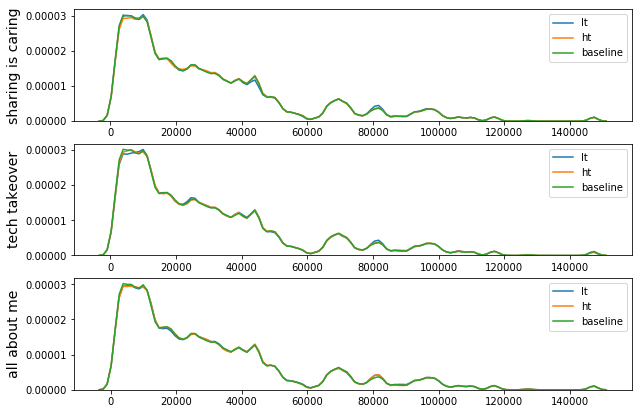

In [94]:
fig, axarr = plt.subplots(3, 1, figsize=(10,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = pd.merge(scenario_dict[scenario + '_' + tech]['home'], zones['min_dist_to_cbd'], left_on='zone_id', right_index=True)
        sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label=tech)
    df = pd.merge(scenario_dict['baseline']['home'], zones['min_dist_to_cbd'], left_on='zone_id', right_index=True)
    sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(scenario_names[scenario], fontsize=14)
# axarr[2].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

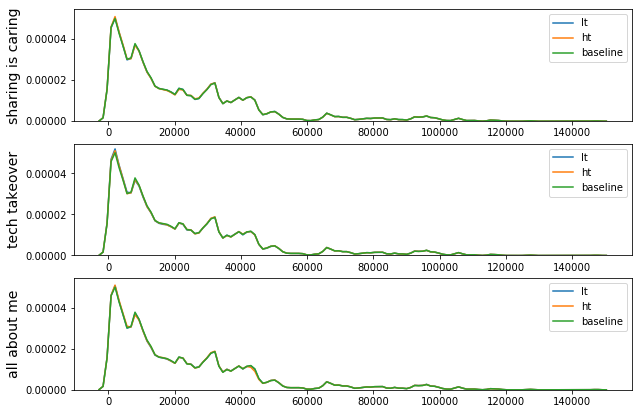

In [192]:
fig, axarr = plt.subplots(3, 1, figsize=(10,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = pd.merge(scenario_dict[scenario + '_' + tech]['work'], zones['min_dist_to_cbd'], left_on='zone_id', right_index=True)
        sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label=tech)
    df = pd.merge(scenario_dict['baseline']['work'], zones['min_dist_to_cbd'], left_on='zone_id', right_index=True)
    sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(scenario_names[scenario], fontsize=14)
# axarr[2].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

Text(0.5, 0, 'Min. dist to Big 3 CBD')

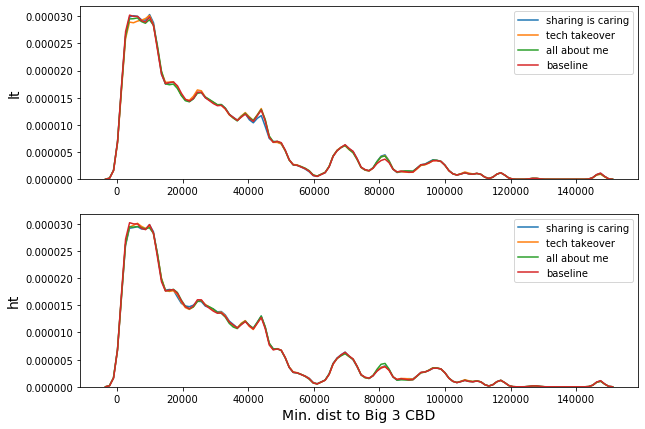

In [190]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = pd.merge(scenario_dict[scenario + '_' + tech]['home'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
        sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label=scenario_names[scenario])
    df = pd.merge(scenario_dict['baseline']['home'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
    sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(tech, fontsize=14)
axarr[1].set_xlabel('Min. dist to Big 3 CBD', fontsize=14)

Text(0.5, 0, 'Min. dist to Big 3 CBD')

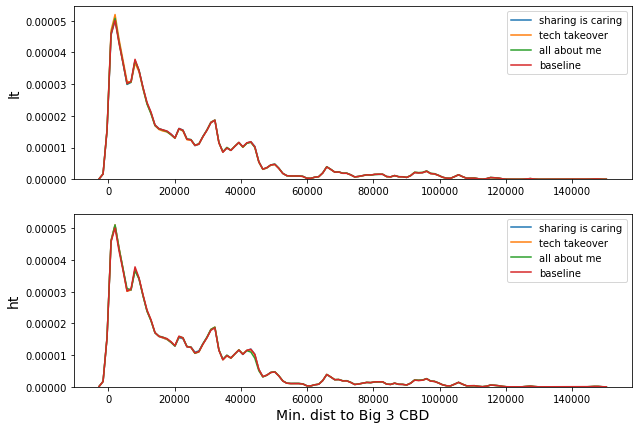

In [191]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = pd.merge(scenario_dict[scenario + '_' + tech]['work'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
        sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label=scenario_names[scenario])
    df = pd.merge(scenario_dict['baseline']['work'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
    sns.kdeplot(df['min_dist_to_cbd'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(tech, fontsize=14)
axarr[1].set_xlabel('Min. dist to Big 3 CBD', fontsize=14)

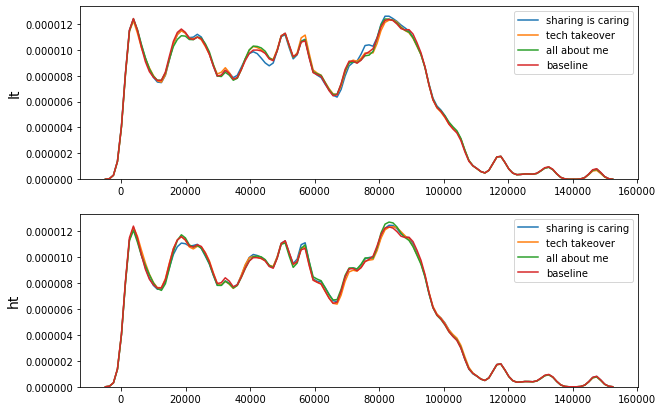

In [96]:
fig, axarr = plt.subplots(2, 1, figsize=(10,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = pd.merge(scenario_dict[scenario + '_' + tech]['home'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
        sns.kdeplot(df['dist_to_embarcadero'], ax=axarr[i], label=scenario_names[scenario])
    df = pd.merge(scenario_dict['baseline']['home'], zones[['dist_to_embarcadero','min_dist_to_cbd']], left_on='zone_id', right_index=True)
    sns.kdeplot(df['dist_to_embarcadero'], ax=axarr[i], label='baseline')
    axarr[i].set_ylabel(tech, fontsize=14)
# axarr[2].set_xlabel('jobs w/i 15 minutes from each residential unit', fontsize=14)

# Employment Density vs. Accessibility

KeyError: 'a_lt'

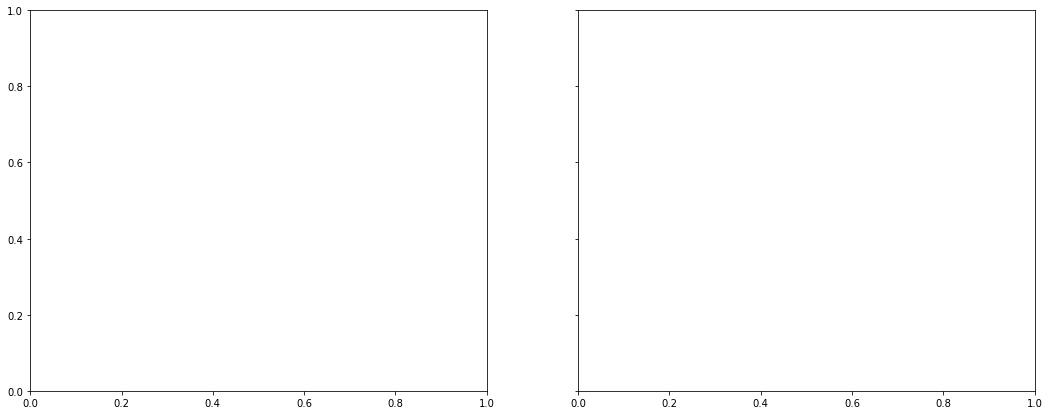

In [50]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'],
            df['jobs_per_sqmi'],
            truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'],
            df['jobs_per_sqmi'],
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('lJobs/Sqmi)', fontsize=14)

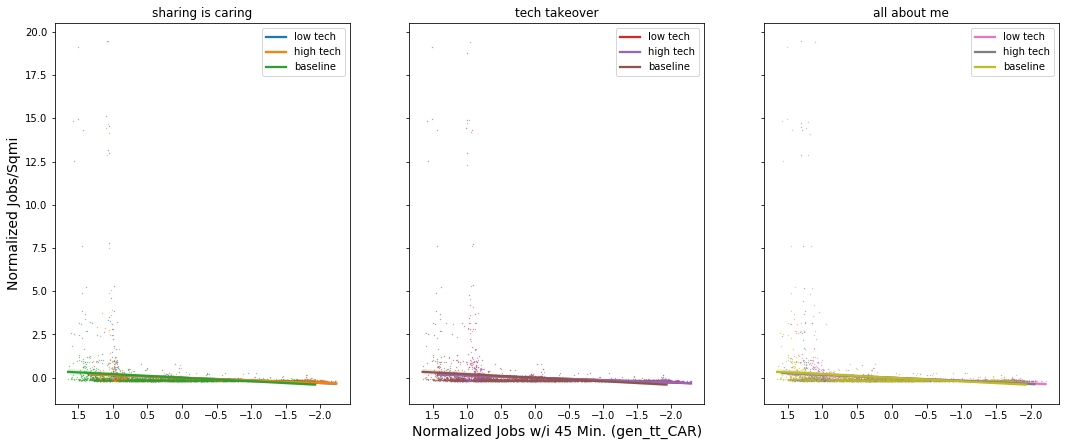

In [196]:
fig, axarr = plt.subplots(1, 3, figsize=(18,7), sharey=True)
for i, scenario in enumerate(['a','b','c']):
    for tech in ['lt', 'ht']:
        df = scenario_dict[scenario + '_' + tech]['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (df['jobs_per_sqmi'] - df['jobs_per_sqmi'].mean()) / df['jobs_per_sqmi'].std(),
            truncate=True,
#             order=3,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':tech_names[tech]}, scatter=True)
    df = scenario_dict['baseline']['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
    sns.regplot(
        (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
        (df['jobs_per_sqmi'] - df['jobs_per_sqmi'].mean()) / df['jobs_per_sqmi'].std(),
        truncate=True,
#             order=2,
        scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(scenario_names[scenario])
#     axarr[i].set_ylim(-0.001,0.05)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
#     for p in axarr[i].findobj(pc):
#         plt.setp(p, alpha=0.35)
axarr[1].set_xlabel('Normalized Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
_ = axarr[0].set_ylabel('Normalized Jobs/Sqmi', fontsize=14)


Text(0, 0.5, 'log(Jobs/Sqmi)')

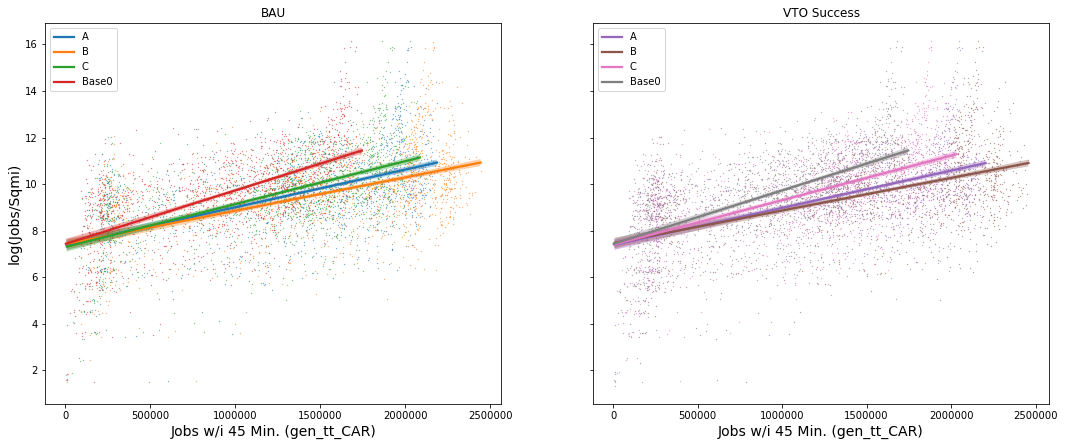

In [45]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        scenario_label = scenario_labels[scenarios.index(scenario + '_' + tech)]
        df = scenario_dict[scenario_label]['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
        sns.regplot(
            df['total_jobs_gen_tt_CAR_45'],
            np.log(df['jobs_per_sqmi']),
            truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario.upper()}, scatter=True)
    df = scenario_dict['Base0']['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['jobs_per_sqmi'] = df['job_id'] / (df['area'] * 3.58701e-8)
    sns.regplot(
            df['total_jobs_gen_tt_CAR_45'],
            np.log(df['jobs_per_sqmi']),
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'Base0'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
#     axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('log(Jobs/Sqmi)', fontsize=14)

Text(0, 0.5, 'log(Jobs/Sqft)')

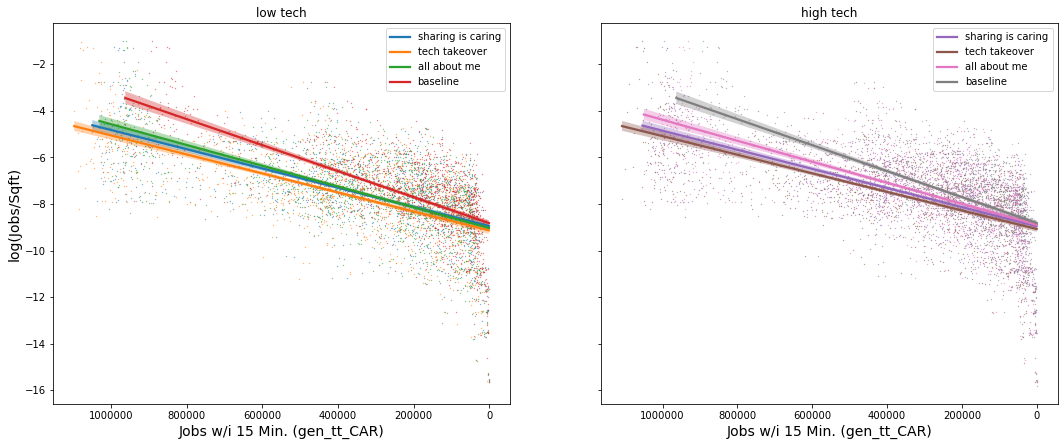

In [146]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
        df['jobs_per_sqft'] = df['job_id'] / df['area']
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'],
            np.log(df['jobs_per_sqft']),
            truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['work'].groupby('zone_id').agg({
            'job_id': 'count', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
    df['jobs_per_sqft'] = df['job_id'] / df['area']
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'],
            np.log(df['jobs_per_sqft']),
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('log(Jobs/Sqft)', fontsize=14)

# Population Density vs. Accessibility

In [149]:
scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'max'})['persons'].sum()

3103404

Text(0, 0.5, 'persons/sqft')

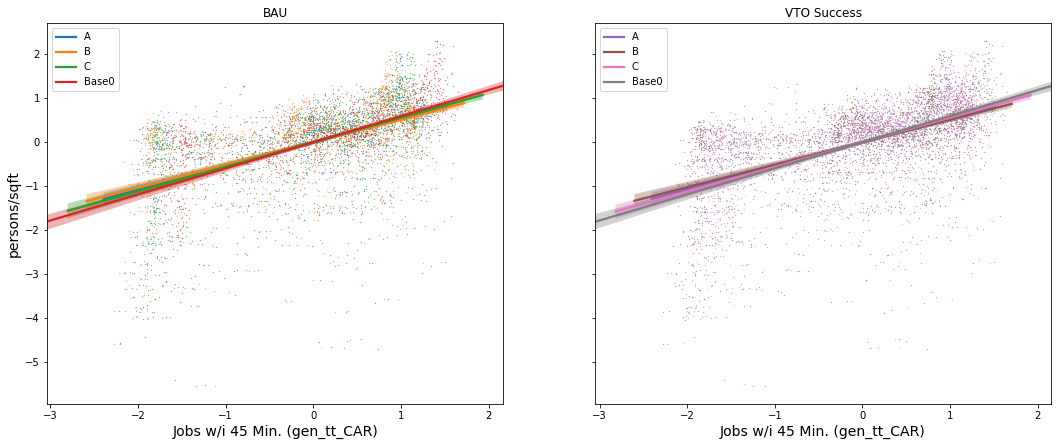

In [84]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        scenario_label = scenario_labels[scenarios.index(scenario + '_' + tech)]
        df = scenario_dict[scenario_label]['home'].groupby('zone_id').agg({
            'persons': 'sum', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['persons_per_sqft'] = df['persons'] / (df['area']) #* 3.58701e-8)
        sns.regplot(
#             df['total_jobs_gen_tt_CAR_45'],
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
#             df['persons_per_sqft'],
#             np.log(df['persons_per_sqft']),

            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
#             truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario.upper()}, scatter=True)
    df = scenario_dict['Base0']['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['persons_per_sqft'] = df['persons'] / (df['area']) #* 3.58701e-8)
    sns.regplot(
#             df['total_jobs_gen_tt_CAR_45'],
        (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
#             df['persons_per_sqft'],
#         np.log(df['persons_per_sqft']),
            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
#         truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'Base0'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
#     axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('persons/sqft', fontsize=14)

Text(0, 0.5, 'Normalized persons/sqft')

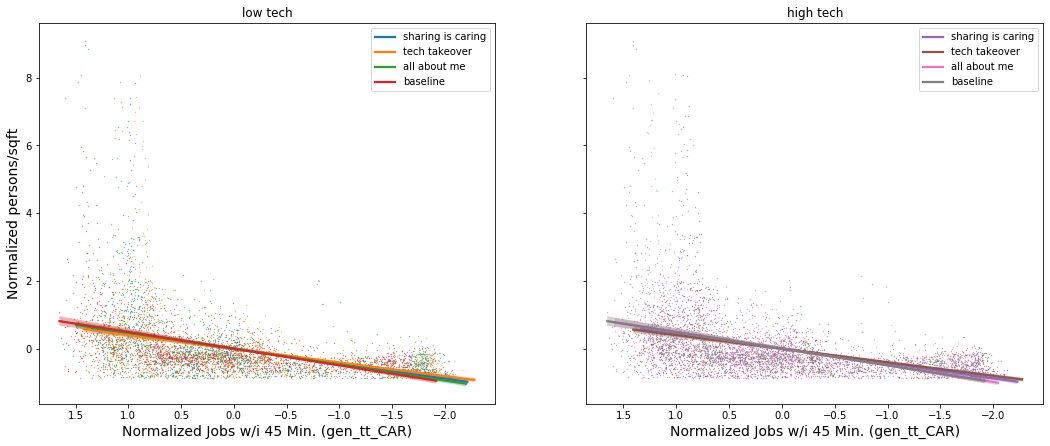

In [174]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').agg({
            'persons': 'sum', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['persons_per_sqft'] = df['persons'] / df['area']
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (df['persons_per_sqft'] - df['persons_per_sqft'].mean()) / df['persons_per_sqft'].std(),
            truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['persons_per_sqft'] = df['persons'] / df['area']
    sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (df['persons_per_sqft'] - df['persons_per_sqft'].mean()) / df['persons_per_sqft'].std(),
        truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Normalized Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Normalized persons/sqft', fontsize=14)

KeyError: 'a_lt'

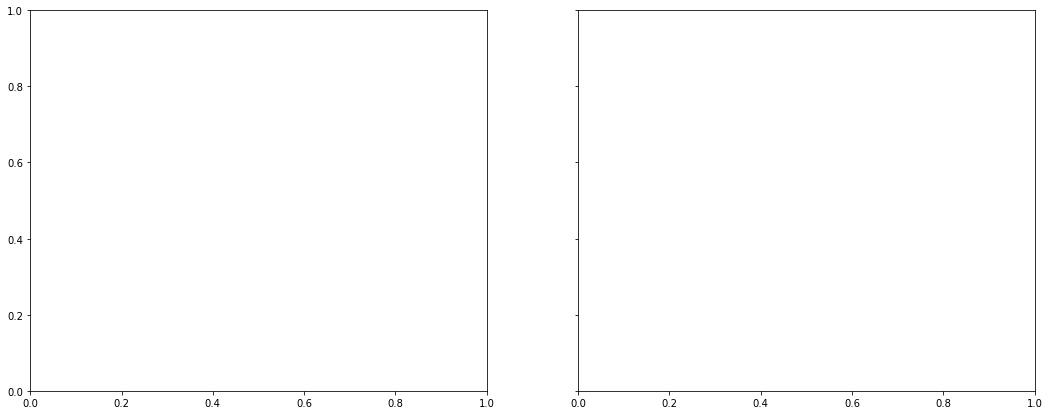

In [51]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').agg({
            'persons': 'sum', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
        df['persons_per_sqft'] = df['persons'] / df['area']
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
            truncate=True,
            order=3,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_45':'mean', 'area':'min'})
    df['persons_per_sqft'] = df['persons'] / df['area']
    sns.regplot(
            (df['total_jobs_gen_tt_CAR_45'] - df['total_jobs_gen_tt_CAR_45'].mean()) / df['total_jobs_gen_tt_CAR_45'].std(),
            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
        truncate=True,
            order=3, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Normalized Jobs w/i 45 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Normalized log(persons/sqft)', fontsize=14)

Text(0, 0.5, 'persons/sqft)')

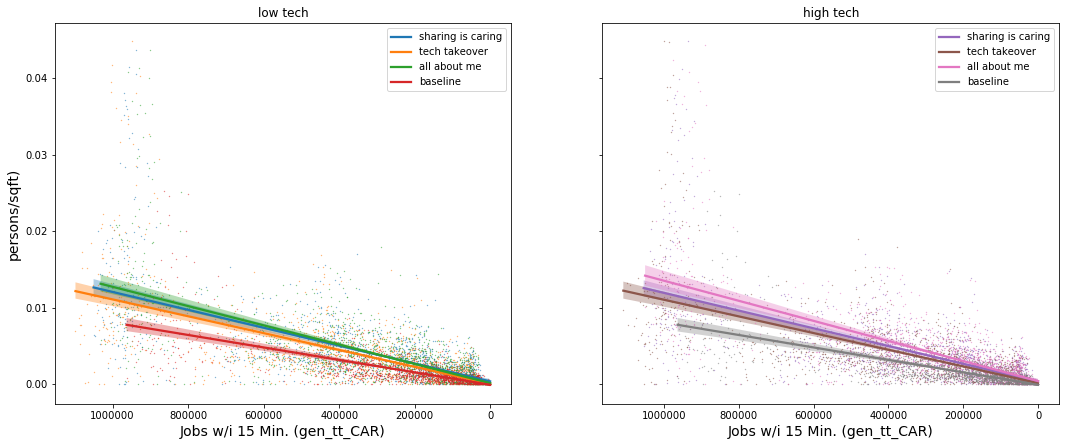

In [160]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').agg({
            'persons': 'sum', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
        df['persons_per_sqft'] = df['persons'] / df['area']
        sns.regplot(
            df['total_jobs_gen_tt_CAR_15'],
            df['persons_per_sqft'],
            truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
    df['persons_per_sqft'] = df['persons'] / df['area']
    sns.regplot(
            df['total_jobs_gen_tt_CAR_15'],
            df['persons_per_sqft'],
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('persons/sqft)', fontsize=14)

Text(0, 0.5, 'Normalized persons/sqft)')

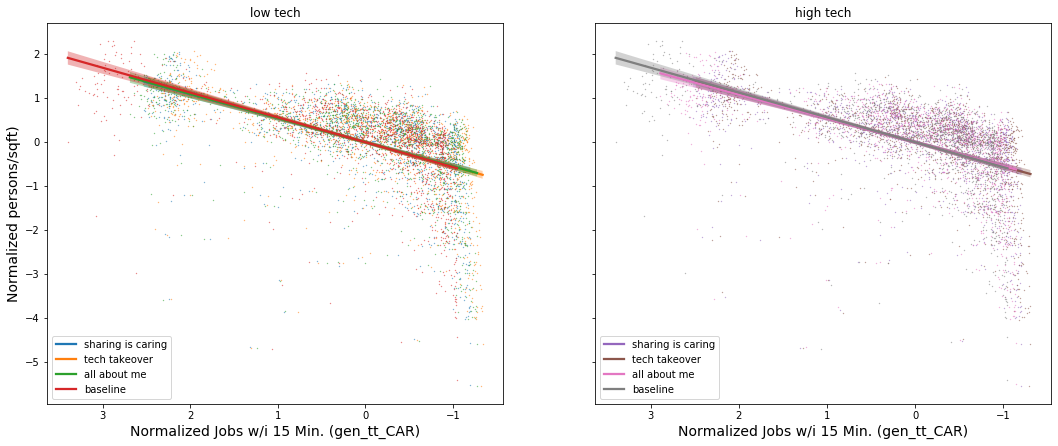

In [178]:
fig, axarr = plt.subplots(1, 2, figsize=(18,7), sharey=True)
for i, tech in enumerate(['lt', 'ht']):
    for scenario in ['a','b','c']:
        df = scenario_dict[scenario + '_' + tech]['home'].groupby('zone_id').agg({
            'persons': 'sum', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
        df['persons_per_sqft'] = df['persons'] / df['area']
        sns.regplot(
            (df['total_jobs_gen_tt_CAR_15'] - df['total_jobs_gen_tt_CAR_15'].mean()) / df['total_jobs_gen_tt_CAR_15'].std(),
            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
            truncate=True,
            order=1,
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':scenario_names[scenario]}, scatter=True)
    df = scenario_dict['baseline']['home'].groupby('zone_id').agg({
            'persons': 'count', 'total_jobs_gen_tt_CAR_15':'mean', 'area':'min'})
    df['persons_per_sqft'] = df['persons'] / df['area']
    sns.regplot(
            (df['total_jobs_gen_tt_CAR_15'] - df['total_jobs_gen_tt_CAR_15'].mean()) / df['total_jobs_gen_tt_CAR_15'].std(),
            (np.log(df['persons_per_sqft']) - np.log(df['persons_per_sqft']).mean()) / np.log(df['persons_per_sqft']).std(),
        truncate=True,
            order=1, 
            scatter_kws={'s':0.1}, 
            ax=axarr[i], line_kws={'label':'baseline'}, scatter=True)
    axarr[i].legend()
    axarr[i].set_ylabel('')
    axarr[i].set_xlabel('')
    axarr[i].title.set_text(tech_names[tech])
    axarr[i].set_xlabel('Normalized Jobs w/i 15 Min. (gen_tt_CAR)', fontsize=14)
    axarr[i].set_xlim(reversed(axarr[i].get_xlim()))
    for p in axarr[i].findobj(pc):
        plt.setp(p, alpha=0.35)
axarr[0].set_ylabel('Normalized persons/sqft)', fontsize=14)

 #  avg genTT plots

In [88]:
scenario_dict['Base0']['work'].head()

job_id  building_id  parcel_id  zone_id          area  \
person_id                                                             
0          4406699.0      1005529    1326106      398  8.724107e+05   
1          3456706.0      1508678    1405355      466  1.680904e+06   
3          4075077.0        91599    1673540      664  1.662829e+06   
4           184397.0      1846423    1316411      372  1.048132e+06   
5          3496279.0       348224    1279912      608  3.279619e+06   

           total_jobs_gen_tt_CAR_45  total_jobs_gen_tt_CAR_30  \
person_id                                                       
0                         1280762.0                  823195.0   
1                         1242800.0                  866687.0   
3                          854142.0                  502612.0   
4                         1295654.0                  855256.0   
5                         1174035.0                  790288.0   

           total_jobs_gen_tt_CAR_15  
person_id                            
0                          236645.0  
1                          431006.0  
3                          100136.0  
4                          285232.0  
5                          289539.0